<a href="https://colab.research.google.com/github/Royal4224/ENM_5320/blob/main/ENM_5320_Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Homework 1\
Author: Roy Wang\
Date: January 29th, 2024


# 1. Derive the least squares solve


# 2. Multilayer Perceptron with Different Dataset

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


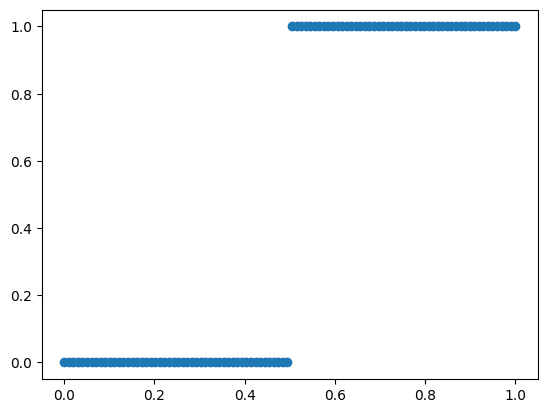

In [38]:
import numpy as np
import matplotlib.pyplot as plt
# Build up original four functions:
def generate_noisylinear_data(N):
    x = np.linspace(0,1,N)
    y = 2*x + 1 + np.random.normal(0,0.2,N)
    return  x,y
def generate_polynomial_data(N):
    x = np.linspace(0,1,N)
    y = x**3 - 2*x**2+x-4.0
    return  x,y
def generate_smoothfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.sin(2.*np.pi*x)
    # modify function here
    return  x,y
def generate_stepfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.float32(x>0.5)
    return  x,y

# Visualize the data
[xdata,ydata] = generate_stepfunction_data(100)
plt.plot(xdata,ydata,'o')
# print(ydata)

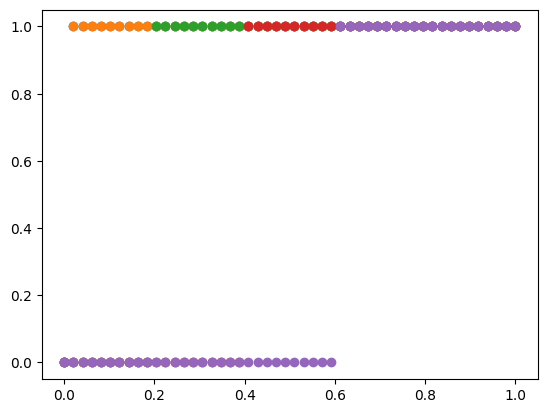

In [39]:
N = 4
M = 50
# Construct N indicator functions defined on M grid points
def generate_indicator_functions(N=4, M=50):
  x = np.linspace(0, 1, M)
  function_pairs = []
  for i in range(N):
    y = np.float32(x > (i / (N + 1)))
    function_pairs.append((x, y))
  return function_pairs

# visualize indicator functions
function_pairs = generate_indicator_functions(N, M)
plt.plot(function_pairs[0][0], function_pairs[0][1], 'o')
for (xdata, ydata) in function_pairs:
  plt.plot(xdata, ydata, 'o')
#print(ydata)

In [40]:
# build tensor based on indicator functions
data_tensor = torch.stack([torch.stack([torch.tensor(xdata, dtype=torch.float32),
                                        torch.tensor(ydata, dtype=torch.float32)]) for (xdata, ydata) in function_pairs])

print(data_tensor.shape) # Output: torch.Size([4, 2, 50])

torch.Size([4, 2, 50])


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define the model (in our case, its y = A*x + b)
class BasisDNNLayer(nn.Module):
    def __init__(self,Nbasis):
        super(BasisDNNLayer, self).__init__()
        # Define a simple MLP with two hidden layer
        self.Nneurons = 40
        self.hidden1 = nn.Linear(1, self.Nneurons)  # 1 input feature, N hidden units
        self.hidden2 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        self.output = nn.Linear(self.Nneurons, Nbasis)  # N hidden units, 1 output feature

    def forward(self, x):
        # We use the ReLU activation function for the hidden layer
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [58]:
# Instantiate the custom layer
layer = BasisDNNLayer(N)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(layer.parameters(), lr=0.001)


In [59]:
dataindex = 1
x_data = data_tensor[dataindex,0,:]
y_data = data_tensor[dataindex,1,:]
# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    basis = layer(x_data.unsqueeze(-1)).squeeze(-1)
    A_mat = torch.einsum('da,db->ab',basis,basis)
    b_vec = torch.einsum('da,fd->af',basis,data_tensor[:,1,:])
    c_vec = torch.linalg.solve(A_mat,b_vec)
    y_fit = torch.einsum('da,af->fd', basis, c_vec)
    error = y_fit - data_tensor[:,1,:]
    loss = torch.mean(error**2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.0351
Epoch [1001/10000], Loss: 0.0046
Epoch [2001/10000], Loss: 0.0046
Epoch [3001/10000], Loss: 0.0131
Epoch [4001/10000], Loss: 0.0033
Epoch [5001/10000], Loss: 0.0034
Epoch [6001/10000], Loss: 0.0033
Epoch [7001/10000], Loss: 0.0045
Epoch [8001/10000], Loss: 0.0033
Epoch [9001/10000], Loss: 0.0068


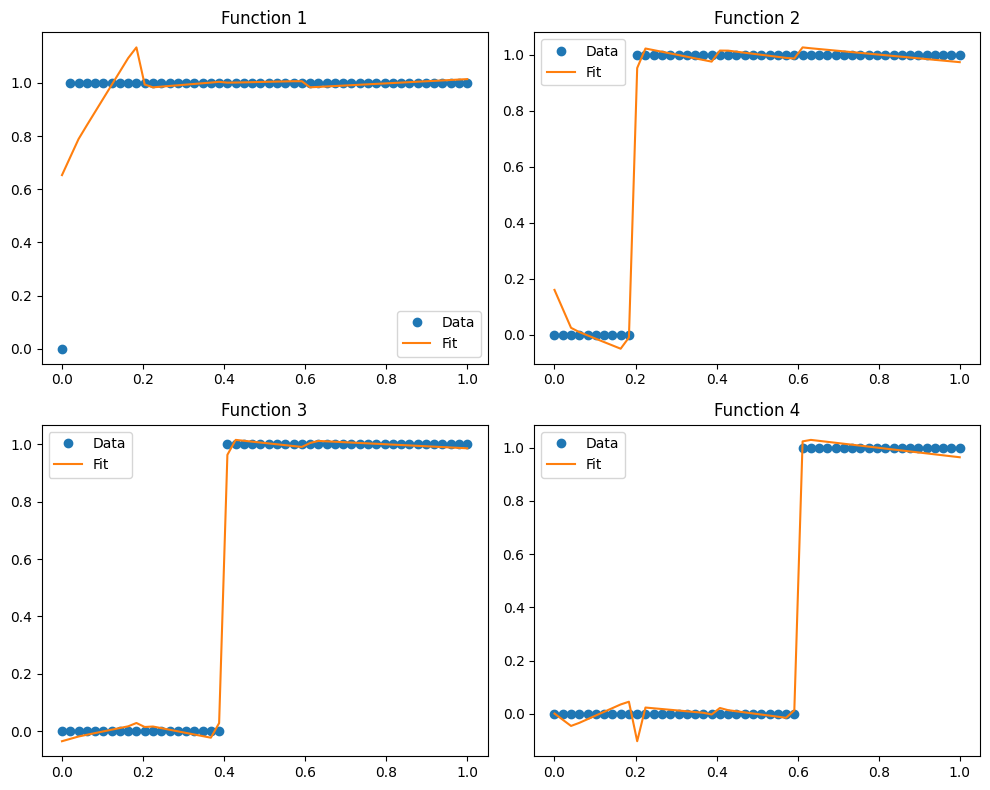

In [60]:
import matplotlib.pyplot as plt

#evaluate the fit function
y_fit = torch.einsum('da,af->fd', basis, c_vec)

# make some plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(N):
    x_data = data_tensor[i, 0, :]
    y_data = data_tensor[i, 1, :]
    fitplot = y_fit[i,:]

    axes[i].plot(x_data.detach().numpy(), y_data.detach().numpy(), 'o', label='Data')
    axes[i].plot(x_data.detach().numpy(), fitplot.detach().numpy(), '-', label='Fit')
    axes[i].set_title(f'Function {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [45]:
# plot basis
